# Import libraries and dataframe

In [163]:
import numpy as np
import pandas as pd


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score
from sklearn.metrics import plot_confusion_matrix
from scoring_functions import scoring_functions as f
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline

# imp allows to reload the above function file when tinkering with it without kernel restart
import imp

import matplotlib.pyplot as plt

In [2]:
# read datafile
df = pd.read_csv('../project_data/complaints_processed.csv')

# clean up by removing NaN's, etc.
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df = df.dropna()
df.drop(df.loc[df['narrative'] == 'name'].index, inplace=True)

# replace class names with integers
product_dict ={'credit_reporting': 0, 'debt_collection': 1, 'mortgages_and_loans': 2, 
               'credit_card': 3, 'retail_banking': 4}
df['product'].replace(product_dict, inplace=True)

# Train-test split

In [4]:
X = df.drop(['product'], axis=1)
y = df['product']

X_train, X_test, y_train, y_test = train_test_split(X['narrative'], y, test_size=0.20, random_state=200)

# Playing with Grid Search

Taking just 5000 datapoints for speed's sake

In [26]:
sample = df.sample(n=5000)

Train test split

In [28]:
X = sample.drop(['product'], axis=1)
y = sample['product']

X_train, X_test, y_train, y_test = train_test_split(X['narrative'], y, test_size=0.20, random_state=200)

Vectorize both training and test set.

In [68]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
vect_X_train = vectorizer.fit_transform(X_train)
vect_X_test = vectorizer.transform(X_test)

Checking out cross validation on basic model

In [34]:
dt = DecisionTreeClassifier()

dt_cv_score = cross_val_score(dt, vect_X_train, y_train, cv=3)

In [35]:
dt_cv_score

array([0.70164918, 0.70517629, 0.69317329])

In [42]:
mean_dt_cv_score = dt_cv_score.mean()
mean_dt_cv_score

0.6999995876030477

In [50]:
print(f"Mean Cross Validation Score: {mean_dt_cv_score :.1%}")

Mean Cross Validation Score: 70.0%


Now try the grid

In [30]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [51]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dt, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(vect_X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [54]:
np.mean(dt_grid_search.cv_results_['mean_train_score'])

0.7348205300432858

In [55]:
dt_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 6,
 'min_samples_split': 10}

Let's try with these params

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X['narrative'], y, test_size=0.20, random_state=200)

In [57]:
dt = DecisionTreeClassifier(criterion='gini',
                            max_depth = None,
                            min_samples_leaf=6,
                            min_samples_split=10)

In [66]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
vect_X_train = vectorizer.fit_transform(X_train)
vext_X_test = vectorizer.transform(X_test)

In [60]:
dt.fit(vect_X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=6, min_samples_split=10)

In [62]:
y_pred = dt.predict(vect_X_train)

Accuracy: 85.5%
Precision: 83.3%
Recall: 77.2%
F1: 79.9%


Classification Report


              precision    recall  f1-score   support

           0       0.88      0.96      0.91      2266
           1       0.79      0.69      0.74       551
           2       0.90      0.74      0.81       463
           3       0.78      0.71      0.74       400
           4       0.82      0.76      0.79       320

    accuracy                           0.85      4000
   macro avg       0.83      0.77      0.80      4000
weighted avg       0.85      0.85      0.85      4000



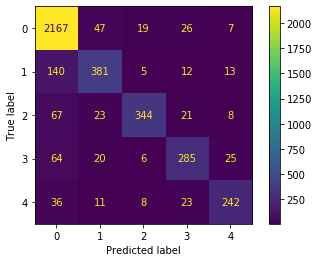

In [63]:
f.scoring(y_train, y_pred, dt, vect_X_train)

Accuracy: 72.3%
Precision: 68.0%
Recall: 61.7%
F1: 64.4%


Classification Report


              precision    recall  f1-score   support

           0       0.77      0.87      0.82       559
           1       0.59      0.47      0.52       159
           2       0.65      0.58      0.62       103
           3       0.60      0.55      0.57        93
           4       0.79      0.62      0.69        86

    accuracy                           0.72      1000
   macro avg       0.68      0.62      0.64      1000
weighted avg       0.71      0.72      0.72      1000



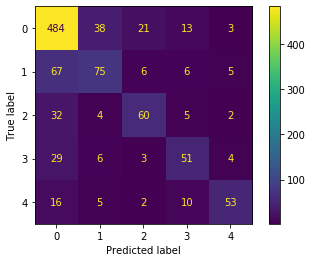

In [69]:
test_y_pred = dt.predict(vect_X_test)
f.scoring(y_test, test_y_pred, dt, vect_X_test)

In [72]:
confusion_matrix(y_test, test_y_pred, labels=[0,1,2,3,4])

array([[484,  38,  21,  13,   3],
       [ 67,  75,   6,   6,   5],
       [ 32,   4,  60,   5,   2],
       [ 29,   6,   3,  51,   4],
       [ 16,   5,   2,  10,  53]], dtype=int64)

In [74]:
cm = confusion_matrix(y_test, test_y_pred, labels=[0,1,2,3,4])

In [80]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

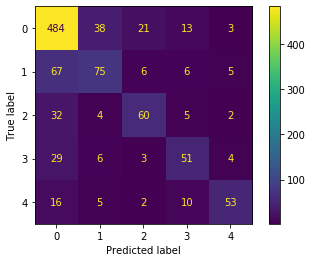

In [81]:
disp = disp.plot()

# Use a function to test for overfitting and make matrices


In [84]:
dt

DecisionTreeClassifier(min_samples_leaf=6, min_samples_split=10)

TRAINING - Classification Report
Accuracy: 85.5%
Precision: 83.3%
Recall: 77.2%
F1: 79.9%
              precision    recall  f1-score   support

           0       0.88      0.96      0.91      2266
           1       0.79      0.69      0.74       551
           2       0.90      0.74      0.81       463
           3       0.78      0.71      0.74       400
           4       0.82      0.76      0.79       320

    accuracy                           0.85      4000
   macro avg       0.83      0.77      0.80      4000
weighted avg       0.85      0.85      0.85      4000

TESTING - Classification Report
Accuracy: 72.4%
Precision: 68.3%
Recall: 62.1%
F1: 64.8%
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       559
           1       0.57      0.48      0.53       159
           2       0.67      0.58      0.62       103
           3       0.60      0.55      0.57        93
           4       0.79      0.63      0.70        86

    ac

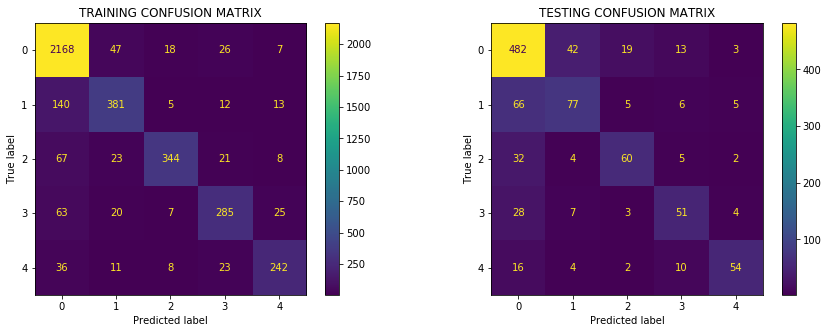

In [138]:
imp.reload(f)
f.run_model(dt, vect_X_train, y_train, vect_X_test, y_test)

# Pipelines

In [140]:
pipeline = Pipeline([('tfidf', TfidfVectorizer()), 
                     ('dt', DecisionTreeClassifier(random_state=123))])

In [150]:
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_features': [1000], 
    'dt__criterion': ['gini'],
    'dt__max_depth': [None, 6],
    'dt__min_samples_split': [2, 10],
    'dt__min_samples_leaf': [4, 6]
}

In [151]:
dt_grid_search = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid,
                              cv=3,
                              return_train_score=True)



In [152]:
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=123))]),
             param_grid={'dt__criterion': ['gini'], 'dt__max_depth': [None, 6],
                         'dt__min_samples_leaf': [4, 6],
                         'dt__min_samples_split': [2, 10],
                         'tfidf__max_features': [1000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             return_train_score=True)

In [153]:
dt_grid_search.best_params_

{'dt__criterion': 'gini',
 'dt__max_depth': 6,
 'dt__min_samples_leaf': 4,
 'dt__min_samples_split': 2,
 'tfidf__max_features': 1000,
 'tfidf__ngram_range': (1, 1)}

In [154]:
dt_grid_search.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=1000)),
                ('dt',
                 DecisionTreeClassifier(max_depth=6, min_samples_leaf=4,
                                        random_state=123))])

In [157]:
dt_grid_search.best_score_

0.7324972172578378

I want to get an idea of tfidf

In [158]:
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_features': [1000,5000, 10000], 
    'dt__criterion': ['gini'],
    'dt__max_depth': [6],
    'dt__min_samples_split': [2],
    'dt__min_samples_leaf': [4]
}

In [159]:
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=123))]),
             param_grid={'dt__criterion': ['gini'], 'dt__max_depth': [None, 6],
                         'dt__min_samples_leaf': [4, 6],
                         'dt__min_samples_split': [2, 10],
                         'tfidf__max_features': [1000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             return_train_score=True)

In [160]:
dt_grid_search.best_params_

{'dt__criterion': 'gini',
 'dt__max_depth': 6,
 'dt__min_samples_leaf': 4,
 'dt__min_samples_split': 2,
 'tfidf__max_features': 1000,
 'tfidf__ngram_range': (1, 1)}

# Naive Bayes

In [177]:
# sampling =  SMOTE()
# X_train_balanced, y_train_balanced = sampling.fit_sample(X_train, y_train)

In [180]:
from imblearn.pipeline import Pipeline 
pipelineNB = Pipeline([('tfidf', TfidfVectorizer()),
                       ('sampling', SMOTE()),
                       ('nb', MultinomialNB())])
# from imblearn.pipeline import Pipeline


In [181]:
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_features': [1000,5000, 10000]
}

In [183]:
nb_grid_search = GridSearchCV(estimator=pipelineNB,
                              param_grid=param_grid,
                              cv=3,
                              return_train_score=True)

nb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('sampling', SMOTE()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tfidf__max_features': [1000, 5000, 10000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             return_train_score=True)

In [184]:
nb_grid_search.best_params_

{'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 1)}

In [185]:
nb_grid_search.best_score_

0.7952501618658038

In [187]:
# you can assign the model to a variable
best_nb = nb_grid_search.best_estimator_

In [188]:
pipelineNB_noSmote = Pipeline([('tfidf', TfidfVectorizer()),
                       ('nb', MultinomialNB())])
# from imblearn.pipeline import Pipeline

In [189]:
nb_grid_search = GridSearchCV(estimator=pipelineNB_noSmote,
                              param_grid=param_grid,
                              cv=3,
                              return_train_score=True)

nb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tfidf__max_features': [1000, 5000, 10000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             return_train_score=True)

In [190]:
nb_grid_search.best_score_

0.7982507246001905